# Logistic Regression for Ancestry Classification from Genetic Data


---

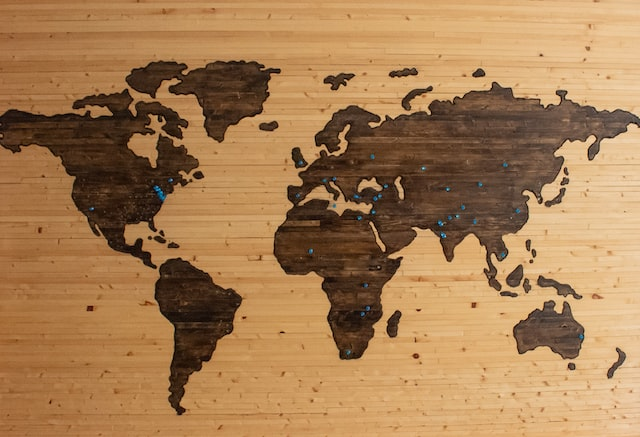

*Given genetic data from a person, can we
predict their ancestry using logistic regression?*

---

Created by Matthew Acs

This project explores the development of a logistic regression model to predict ancestry based on genetic data. The model will be developed from scratch.

*Note: I use the terms weights and model parameters interchangeable to signify the same thing. That is, they mean the model parameters that are obtained via training the model.*

## Data


---


The first step is to prepare the data for the model. This is done by importing the data, exploring it, processing it, splitting it into datasets, and standardizing it.

### Imports and Data Upload


---



The code below imports the necessary dependencies and uploads the data.

In [33]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

url = 'https://raw.githubusercontent.com/Mattliketocode/cuddly-carnival/main/TrainingData_N183_p10.csv'
data_import = pd.read_csv(url)
data_import = data_import.sample(frac=1)

### Data Exploration


---



The following two code cells explore the data. This is important to understand the type of data that is being used and the range of values that are present. From the data exploration we can see the top 10 principal components of the genetic data along with the ancestry classification. The classification labels must be encoded in the data preprocessing to be able to train the model.

In [34]:
data_import.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
123,3.452450,5.331635,6.562218,-1.824789,0.259692,0.238215,-0.820916,-0.237096,-1.899390,-0.671274,Oceanian
69,5.179862,5.028177,0.001786,3.272821,-0.204087,0.027597,-0.541490,-0.403049,0.787064,-0.671274,EastAsian
89,5.078192,4.230245,0.564029,2.990391,0.678145,-1.514565,2.074669,0.325879,2.531303,-0.671274,EastAsian
63,4.064421,4.435673,0.162694,3.582953,-1.127786,-0.355579,-1.379794,2.414027,-0.923999,0.885596,EastAsian
68,3.873890,4.527507,1.075195,3.930277,0.448953,0.000442,2.885989,-0.475726,2.225377,-0.671274,EastAsian


In [35]:
data_import.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,1.404880,2.022935,0.001913,0.102812,0.243929,0.293902,0.043762,-0.185769,0.103880,-0.041720
std,4.912770,3.486088,3.919764,3.158607,2.146196,1.775345,1.590285,1.508038,1.585749,0.979746
min,-13.319922,-6.790059,-7.682406,-5.578577,-3.738619,-3.750904,-4.658872,-4.637746,-3.805225,-0.671274
25%,1.378429,0.693607,-1.670439,-2.218318,-0.689892,-0.778750,-0.814203,-1.150829,-0.961702,-0.671274
50%,3.078680,2.891455,-0.216789,-0.158435,0.104254,0.166350,0.087942,-0.179818,0.127011,-0.671274
75%,4.306548,4.258144,1.274309,3.276286,0.782704,1.127730,0.975648,0.733770,1.233731,0.885596
max,5.811956,7.582173,8.938295,5.892653,13.195087,6.004057,5.140476,3.908339,3.739434,2.442467


### Data Preprocessing


---



The code below processes the labels by converting them to an encoding scheme that can be used to train the model.

In [36]:
data = data_import.to_numpy()

for x in data:
  if x[10] == 'African':
    x[10] = 0
  elif x[10] == 'European':
    x[10] = 1
  elif x[10] == 'EastAsian':
    x[10] = 2
  elif x[10] == 'Oceanian':
    x[10] = 3
  elif x[10] == 'NativeAmerican':
    x[10] = 4

data = np.array(data, dtype='float')

data_set = []
labels = np.zeros((183, 5))
count = 0
for x in data:
  temp_data = x[0 : 10]
  temp_data = np.insert(temp_data,0,1)
  data_set.append(temp_data)
  labels[count][int(x[10])] = 1
  count = count + 1
  
data = np.array(data_set, dtype='float')
labels = np.array(labels, dtype = 'float')

pre_data_set = []
count = 0
for x in data:
  temp_data = x
  temp_data = np.append(temp_data, labels[count])
  pre_data_set.append(temp_data)
  count = count + 1

data = np.array(pre_data_set, dtype='float')

### Dataset standardization and preparation


---



The next step is to split and standardize the data. The dataset is split into a set containing all 183 data entries and five datasets for five fold cross validation. Each of these datasets are then standardized. This is done by subtracting the mean from each feature and dividing by the standard deviation. The validation datasets are standardized according to their respective training dataset standardization parameters in order to retain the correct scale for the data.

In [37]:
def standardize(data, val_data = []):
  if len(val_data) == 0:
    means = np.mean(data, 0)
    stdev = np.std(data, 0)
    stdev[0] = 1
    std_data = (data-means)/stdev
    return std_data
  else:
    means = np.mean(data, 0)
    stdev = np.std(data, 0)
    stdev[0] = 1
    std_data = (val_data-means)/stdev
    return std_data

In [38]:
train_splits = {}
for i in range(5):
  train_splits[i] = []

val_splits = {}
for i in range(5):
  val_splits[i] = []

for i in range(5):
  for j in range(183):
    if (j < i*36) or (j >= (i+1) * 36):
      train_splits[i].append(data[j])
    else:
      val_splits[i].append(data[j])

for i in range(5):
  train_splits[i] = np.array(train_splits[i])
  val_splits[i] = np.array(val_splits[i])

X_train = {}
y_train = {}
for i in range(5):
  X_train[i] = standardize(train_splits[i][:, 0:11])
  y_train[i] = train_splits[i][:, 11:16]

X_val = {}
y_val = {}
for i in range(5):
  X_val[i] = standardize(train_splits[i][:, 0:11], val_splits[i][:, 0:11])
  y_val[i] = val_splits[i][:, 11:16]

X_full = standardize(data[:, 0:11])
y_full = data[:, 11:16]

## Logistic Regression from Scratch



---



Now that the data is prepared, logistic regression will be implemented from scratch.

### Logistic Regression Algorithm


---



The code below defines a logistic regression function that takes a learning rate alpha, constraint parameter lmbda, and the data. It returns the trained model parameters.

In [39]:
def logistic(alpha, lmbda, X, y):
  B = np.zeros((11, 5))

  for repeat in range(10000):
    U = np.dot(X, B)
    for i in range(len(U)):
      for k in range(len(U[i])):
        U[i][k] = math.exp(U[i][k])

    P = np.zeros((len(X),5))
    for i in range(len(P)):
      for k in range(len(P[i])):
        sum = 0
        for l in range(len(P[i])):
          sum = U[i][l] + sum
        P[i][k] = U[i][k] / (sum)

    Z = np.zeros((11, 5))
    Z[0] = B[0]

    B = B + alpha * (np.dot(np.transpose(X), (y-P)) - ((2*lmbda)*(B-Z)))

  return B

### Full Dataset Training



---



The code below trains nine models based on lambda parameters from 0.0001 to 10000. Alpha is set to the value 0.00001. The parameters for each feature are then graphed to show the impact of the lambda parameter. As the parameter increases, the model becomes more constrained and the parameters tend to zero to minimize the penalized cost function. The graphs also show how the parameters differ for each class.

In [40]:
weights = {}
alpha = 0.00001
for i in range(9):
    weights[i] = logistic(alpha, 0.0001 * (10**i), X_full, y_full)

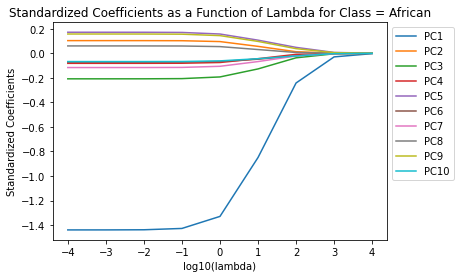

In [41]:
features = {}
for i in range(11):
    features[i] = []

for i in range(11):
  for j in range(9):
    features[i].append(weights[j][i])

for i in range(11):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[1] = "PC1"
feature_names[2] = "PC2"
feature_names[3] = "PC3"
feature_names[4] = "PC4"
feature_names[5] = "PC5"
feature_names[6] = "PC6"
feature_names[7] = "PC7"
feature_names[8] = "PC8"
feature_names[9] = "PC9"
feature_names[10] = "PC10"

plt.title("Standardized Coefficients as a Function of Lambda for Class = African")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(1, 11):
  plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], np.array(features[i])[:, 0:1], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

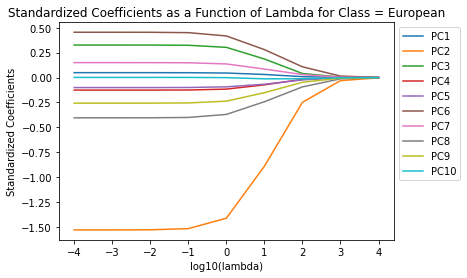

In [42]:
features = {}
for i in range(11):
    features[i] = []

for i in range(11):
  for j in range(9):
    features[i].append(weights[j][i])

for i in range(11):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[1] = "PC1"
feature_names[2] = "PC2"
feature_names[3] = "PC3"
feature_names[4] = "PC4"
feature_names[5] = "PC5"
feature_names[6] = "PC6"
feature_names[7] = "PC7"
feature_names[8] = "PC8"
feature_names[9] = "PC9"
feature_names[10] = "PC10"

plt.title("Standardized Coefficients as a Function of Lambda for Class = European")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(1, 11):
  plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], np.array(features[i])[:, 1:2], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

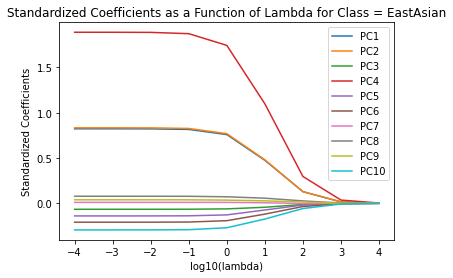

In [43]:
features = {}
for i in range(11):
    features[i] = []

for i in range(11):
  for j in range(9):
    features[i].append(weights[j][i])

for i in range(11):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[1] = "PC1"
feature_names[2] = "PC2"
feature_names[3] = "PC3"
feature_names[4] = "PC4"
feature_names[5] = "PC5"
feature_names[6] = "PC6"
feature_names[7] = "PC7"
feature_names[8] = "PC8"
feature_names[9] = "PC9"
feature_names[10] = "PC10"

plt.title("Standardized Coefficients as a Function of Lambda for Class = EastAsian")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(1, 11):
  plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], np.array(features[i])[:, 2:3], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

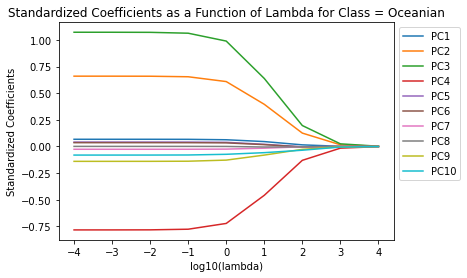

In [44]:
features = {}
for i in range(11):
    features[i] = []

for i in range(11):
  for j in range(9):
    features[i].append(weights[j][i])

for i in range(11):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[1] = "PC1"
feature_names[2] = "PC2"
feature_names[3] = "PC3"
feature_names[4] = "PC4"
feature_names[5] = "PC5"
feature_names[6] = "PC6"
feature_names[7] = "PC7"
feature_names[8] = "PC8"
feature_names[9] = "PC9"
feature_names[10] = "PC10"

plt.title("Standardized Coefficients as a Function of Lambda for Class = Oceanian")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(1, 11):
  plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], np.array(features[i])[:, 3:4], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

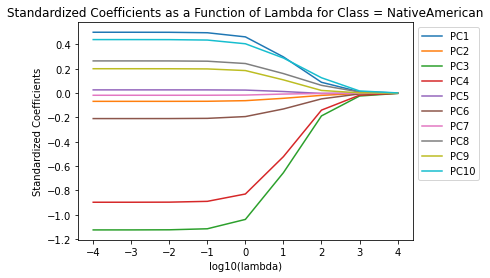

In [45]:
features = {}
for i in range(11):
    features[i] = []

for i in range(11):
  for j in range(9):
    features[i].append(weights[j][i])

for i in range(11):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[1] = "PC1"
feature_names[2] = "PC2"
feature_names[3] = "PC3"
feature_names[4] = "PC4"
feature_names[5] = "PC5"
feature_names[6] = "PC6"
feature_names[7] = "PC7"
feature_names[8] = "PC8"
feature_names[9] = "PC9"
feature_names[10] = "PC10"

plt.title("Standardized Coefficients as a Function of Lambda for Class = NativeAmerican")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(1, 11):
  plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], np.array(features[i])[:, 4:5], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

### 5 - Fold Cross Validation Training



---



In order to find which lambda parameter is the most optimal for this model, the code below calculates the cross-validation error of each lambda value based on five-fold cross validation. The cross-validation error is computer using categorical cross entropy calculations. The graph and output show that the best lambda value is 10^-4.

The cell below trains the model based on 5-fold cross validation.

In [46]:
k_fold_weights = {}
for i in range(5):
  k_fold_weights[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

alpha = 0.00001
for i in range(5):
  for j in range(9):
      k_fold_weights[i][j] = logistic(alpha, 0.0001 * (10**j), X_train[i], y_train[i])

The cell below generates predictions for the validation data.

In [47]:
predictions = {}
probabilities = {}
for i in range(5):
  predictions[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  probabilities[i] = np.zeros((9,36))

for i in range(5):
  for j in range(9):
    predictions[i][j] = np.dot(X_val[i],k_fold_weights[i][j])

for i in range(5):
  for j in range(9):
    for k in range(36):
      for l in range(5):
        predictions[i][j][k][l] = math.exp(predictions[i][j][k][l])

for i in range(5):
  for j in range(9):
    for k in range(36):
      for l in range(5):
        probabilities[i][j][k] = probabilities[i][j][k] + predictions[i][j][k][l]

for i in range(5):
  for j in range(9):
    for k in range(36):
      for l in range(5):
        predictions[i][j][k][l] = predictions[i][j][k][l] / probabilities[i][j][k]

The cell below calculates the categorical cross entropy values.

In [48]:
CCE = [[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]]
for i in range(5):
  for j in range(9):
    for k in range(36):
      for l in range(5):
        CCE[i][j] = CCE[i][j] + (y_val[i][k][l] * math.log10(predictions[i][j][k][l]))
    CCE[i][j] = (-1/36) * CCE [i][j]

The cell below uses the categorical cross entropy values to calculate the cross validation scores.

In [49]:
CV = {}
for i in range(9):
  CV[i] = (CCE[0][i] + CCE[1][i] + CCE[2][i] + CCE[3][i] + CCE[4][i])/5

Finally, the lambda vs CV error plot is generated.

+--------+----------------------+
| Lambda |       CV Error       |
+--------+----------------------+
| 10^-4  | 0.04732982158554289  |
| 10^-3  | 0.04733975740095321  |
| 10^-2  | 0.04743915053022647  |
| 10^-1  | 0.048436521963695266 |
|  10^0  | 0.05869858761976794  |
|  10^1  | 0.15935101994064066  |
|  10^2  | 0.49942558058948405  |
|  10^3  |  0.6731424492010885  |
|  10^4  |  0.6963189463443483  |
+--------+----------------------+

The value of lambda that generated the smallest CV error is 10^-4




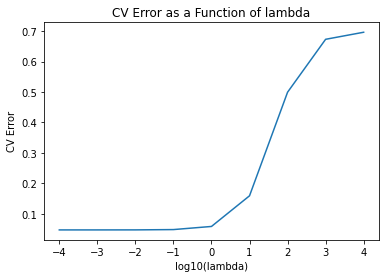

In [50]:
x = PrettyTable()
x.field_names = ["Lambda", "CV Error"]

cross_validation = []

for i in range(9):
  cross_validation.append(CV[i])
  x.add_row(["10^" + str(i-4), str(CV[i])])

print(x)
print("")
print("The value of lambda that generated the smallest CV error is 10^-4")
print("")

plt.title("CV Error as a Function of lambda")
plt.xlabel("log10(lambda)")
plt.ylabel("CV Error")
plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], cross_validation)
print("")

### Final Best Fit Model Parameters



---



The code below trains the logistic regression model on the entire dataset and prints the best-fit model parameters. The value for lambda was based on the results we got from the five-fold cross validation.

In [51]:
alpha = 0.00001
final_weights = logistic(alpha, 0.0001, X_full, y_full)

print("Best fit model parameters")
print("-------------------------")
print("")
print(final_weights)

Best fit model parameters
-------------------------

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.43904835e+00  4.89829749e-02  8.21976712e-01  6.77073951e-02
   5.00381272e-01]
 [ 1.03009924e-01 -1.52813274e+00  8.32811762e-01  6.59781551e-01
  -6.74704944e-02]
 [-2.08233083e-01  3.26131591e-01 -6.57781890e-02  1.07188140e+00
  -1.12400172e+00]
 [-8.19703956e-02 -1.25843634e-01  1.88718470e+00 -7.82794274e-01
  -8.96576401e-01]
 [ 1.71229189e-01 -1.00505096e-01 -1.39039649e-01  4.15123483e-02
   2.68032082e-02]
 [-7.26215766e-02  4.54396813e-01 -2.08382274e-01  3.57241007e-02
  -2.09117063e-01]
 [-1.16308054e-01  1.49693893e-01  1.02302512e-02 -2.61292384e-02
  -1.74868515e-02]
 [ 5.98122217e-02 -4.03871924e-01  7.82727185e-02  9.66680678e-04
   2.64820303e-01]
 [ 1.56846869e-01 -2.56845107e-01  3.88439080e-02 -1.39440266e-01
   2.00594597e-01]
 [-6.76061547e-02  1.57825745e-03 -2.93475221e-01 -8.05379497e-02
   4.40041068e-01]]


The best model was the least constrained. As the lambda value increased, the cross-validation error also increased. This is interesting because the constraint parameter typically prevents overfitting, which helps generalize the model to increase performance on validation data. This did not occur, which may be because the features that were used were based on principle components. These features can be considered highly informative, which may increase generalizability. This may be related to the distinct graphs that were created for each of the classes when the model parameters were graphed. Each classification had a distinct signature, with certain features having much greater coefficients than the rest.

### Test Data



---



The final step is to test the model using an external dataset. The code below imports, explores, and prepares a test dataset.

In [52]:
url = 'https://raw.githubusercontent.com/Mattliketocode/cuddly-carnival/main/TestData_N111_p10.csv'
test_data_import = pd.read_csv(url)

In [53]:
test_data_import.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,2.517683,5.464283,9.067873,-4.965928,-0.741937,0.039785,0.573279,-0.216918,2.454823,-0.671274,Unknown
1,6.077012,1.032867,-5.795883,-3.490064,-0.600204,-0.120803,1.243767,1.821390,-1.173053,2.442467,Unknown
2,1.016945,-2.913299,0.907702,1.233580,-1.983452,1.605964,2.674998,-0.732921,-2.157438,-0.671274,Unknown
3,-10.860926,2.545077,0.023950,-1.474450,0.372286,-2.609954,-2.794092,1.264747,-3.974644,-0.671274,Unknown
4,4.790262,3.621650,-1.442221,5.459907,-0.864235,-2.591185,-0.062762,0.515344,0.228729,-0.671274,Unknown


In [54]:
test_data_import.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,-2.428559,0.067684,-1.493551,-0.573465,-0.523544,0.063552,0.002549,-0.271733,-0.301580,0.086122
std,5.711764,1.785841,1.737356,1.570952,1.684093,1.998561,1.961055,2.005613,1.571386,1.046801
min,-12.099310,-3.626565,-5.796923,-4.965928,-4.193899,-5.595230,-4.611258,-5.298648,-4.827428,-0.671274
25%,-7.940556,-1.150346,-2.585205,-1.589435,-1.678536,-1.169095,-1.127837,-1.276366,-1.182661,-0.671274
50%,1.016945,0.085142,-1.392893,-0.659949,-0.639072,-0.084256,-0.062762,-0.336890,-0.217657,-0.671274
75%,2.881532,1.306610,-0.714361,0.291034,0.614935,1.178394,1.069038,0.869861,0.554207,0.885596
max,6.077012,5.464283,9.067873,5.459907,3.830077,4.979169,6.567931,4.683556,5.002221,2.442467


The cell below prepares the datasets from the csv file.

In [55]:
data_1 = test_data_import.to_numpy()
data = test_data_import.to_numpy()

for x in data:
  if x[10] == 'Unknown':
    x[10] = 0
  elif x[10] == 'Mexican':
    x[10] = 1
  elif x[10] == 'AfricanAmerican':
    x[10] = 2

data = np.array(data, dtype='float')

data_set = []
labels = np.zeros((111, 3))
count = 0
for x in data:
  temp_data = x[0 : 10]
  temp_data = np.insert(temp_data,0,1)
  data_set.append(temp_data)
  labels[count][int(x[10])] = 1
  count = count + 1
  
data = np.array(data_set, dtype='float')
labels = np.array(labels, dtype = 'float')

pre_data_set = []
count = 0
for x in data:
  temp_data = x
  temp_data = np.append(temp_data, labels[count])
  pre_data_set.append(temp_data)
  count = count + 1

data = np.array(pre_data_set, dtype='float')

The data is then standardized in the cell below.

In [56]:
X_test = standardize(data[:, 0:11])
y_test = data[:, 11:16]

Finally, the test data is used along with the best fit model parameters to generate predictions.

In [57]:
predictions = np.dot(X_test,final_weights)
probabilities = np.zeros(111)

for k in range(111):
  for l in range(5):
    predictions[k][l] = math.exp(predictions[k][l])

for k in range(111):
  for l in range(5):
    probabilities[k] = probabilities[k] + predictions[k][l]

for k in range(111):
  for l in range(5):
    predictions[k][l] = predictions[k][l] / probabilities[k]

discrete_predictions = np.argmax(predictions, 1)

The predictions for each test input are printed below. The probabilities of each ancestry along with the discrete class prediction are printed.

In [58]:
print("Prediction Indices Key:")
print("0 = African")
print("1 = European")
print("2 = EastAsian")
print("3 = Oceanian")
print("4 = NativeAmerican")
print("-----------------------")
print("")
print("Probabilites for each test datapoint:")
print(predictions)
print("")
print("Discrete predictions for each test datapoint:")
print(discrete_predictions)
print("")
print("Actual Labels")
print(data_1[:,10:11])

Prediction Indices Key:
0 = African
1 = European
2 = EastAsian
3 = Oceanian
4 = NativeAmerican
-----------------------

Probabilites for each test datapoint:
[[4.48801414e-06 1.72573011e-06 2.88208431e-06 9.99990485e-01
  4.18904130e-07]
 [3.26181891e-04 3.70132782e-04 1.85052941e-04 7.30445040e-04
  9.98388187e-01]
 [2.55041326e-03 9.17121536e-01 6.62762485e-02 1.31722851e-02
  8.79516808e-04]
 [3.92579746e-01 3.73166526e-03 1.85031162e-02 5.76378531e-01
  8.80694158e-03]
 [4.54190997e-06 3.52773919e-07 9.99988469e-01 5.14531885e-06
  1.49142933e-06]
 [3.55924142e-03 1.55308557e-02 3.24664588e-04 2.55699608e-03
  9.78028242e-01]
 [7.64840650e-03 3.81053236e-02 1.10576462e-03 2.41584551e-02
  9.28982050e-01]
 [1.78099817e-02 1.75380437e-01 2.09959670e-02 2.98680366e-02
  7.55945578e-01]
 [2.07441734e-02 5.45674409e-02 1.49161849e-02 1.73791016e-02
  8.92393099e-01]
 [2.53370157e-02 4.95847080e-01 1.98990091e-02 2.59428143e-02
  4.32974081e-01]
 [1.14647512e-02 1.44912839e-01 1.45064122

The class label probabilities for the Mexican data entries are typically discretely predicted to either be European or Native American. This is also mirrored in the probabilities for each class, with Mexican data entries having large probabilities of being classified as European or Native American. In contrast, African American data entries have high probabilities of being classified as African, East Asian, and Oceanian. However, some African American data entries have high probabilities for all five classes. This is evident in both the probabilities and discrete predictions. This contrasts with the unknown samples, because the unknown samples have a very high probability of being only one ancestry. African American and Mexican data entries have mixed probabilities, with several ancestries being likely. The mixed probabilities predicted for the Mexican and African American data entries are reasonable because they reflect recent historical trends. Many people from Mexico have ancestors that are both Native Americans and European. This is because populations of European explorers and Native Americans combined to form what is now present-day Mexico. This is reflected in the high probabilities for the Mexican data entries to be classified as either European or Native American. Similarly, African Americans have their roots in the African continent. Many African Americans were brought to the United States as slaves in the 17th and 18th centuries. However, some slaves were brought from other places, includes areas with Asian and Oceanian ancestry. Then, slave population mixed in the United States. Once slavery was abolished, African Americans mixed with populations of Europeans and Native Americans in the United States. This historical origin is reflected in the mixed probabilities output by the model for the African American data entries. However, a majority of the discrete predictions for the African American data points is African, which is reasonable given the historical origin of many African Americans.

## Discussions and Conclusions

---
Overall, the assignment demonstrated that a logistic regression model can be created from scratch to model the top 10 principal components from human genetic data in order to predict ancestry. The model was able to accurately predict the ancestry of the data based on cross validation metrics. The test data of mixed origin was also able to validate the model. The probabilities outputted by the model reflected the historical origin of each ethnic group. The cross validation also showed that the best lambda parameter was the least restrictive. This could be due to the fact that the datasets derived from PCA rather than raw data metrics. Finally, the project reflects the fact that human genetic markers can convey the history of an individual. Populations of individuals living in the same region have similar genetic profiles because they have been isolated together. These genetic similarities are modeled by the logistic regression algorithm in order to differentiate between different populations of people. However, as the world becomes increasingly globalized, individuals are more likely to have mixed ancestries such as the individuals used in the test data set.

### References

---

The sources below are links to various resources that I utilized while working on this project.

- Photo by <a href="https://unsplash.com/@iambrettzeck?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Brett Zeck</a> on <a href="https://unsplash.com/s/photos/map?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
  

> *Image credit for cover photo*

- https://numpy.org/

> *NumPy doccumentation*

- https://pandas.pydata.org/

> *pandas doccumentation*

- https://matplotlib.org/

> *Matplotlib doccumentation*

- https://pypi.org/project/prettytable/

> *PrettyTable doccumentation*